## Setup
First, we're going to import our required modules and setup MatplotLib.

In [3]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Now, we'll add a folder to save the figures to:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## KMNIST
This dataset is based on the MNIST dataset, however instead of using arabic numerals, we are using Japanese hiragana.

 **Disclaimer:** Before we begin the project, I want to point out that the quality of the writing is fairly inconsistent. Even as a human who has studied the language, I found some of the data to be quite messsy and prone to causing errors. Nevertheless, I believe it is more interesting to try this anyways, instead of re-using the MNIST data and finding the same results that were found in the textbook.

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('Kuzushiji-MNIST', as_frame=False)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now, we take a look at what an example of our data will be

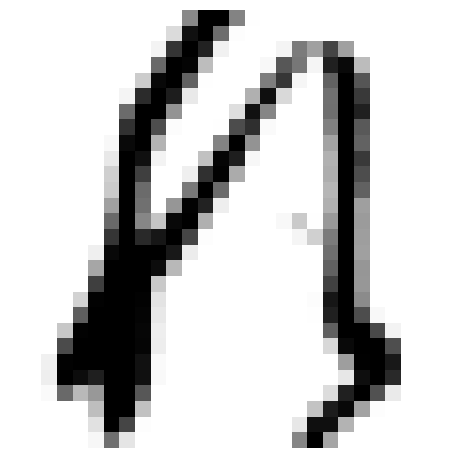

'8'

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()
y[0]

This gives us a good idea of the type of data will see. Is this supposed to be れ？ね？our value of y shows that it's the 8th index, so it is indeed れ.


Now, let's see what else we have in store with this dataset.

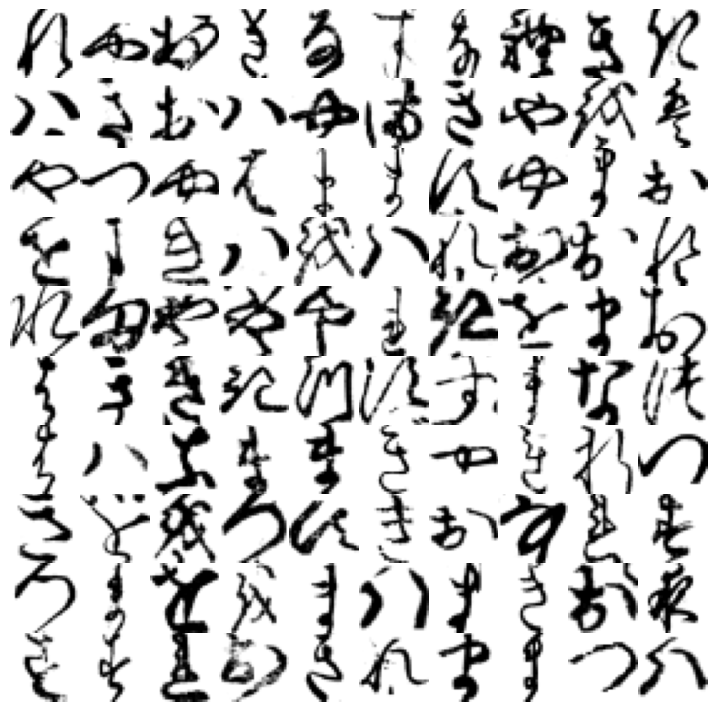

In [8]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

Definitely a lot worse.... personally I'd have a lto of difficulty figuring out some of these. We'll find out if we can do better using machine learning!

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training the Binary Classifier

In [10]:
y_train_5 = (y_train == '5')  # True for all 5s (in this case, は)
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # We set the random state for reproduceable results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([False])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.94645, 0.95775, 0.9472 ])

95%?!? Clearly this isn't right. The reason it acts this way is because there are more options that are "false", and so if it guesses "false", it has a 90% chance of being correct.

So, we will instead look at a confusion matrix to gain a better understanding of how the model is working.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[52842,  1158],
       [ 1814,  4186]], dtype=int64)

So, this allows to see that there were 2972 type 1 and 2 errors.

## Precision and Recall
We can use the following functions to calculate the precision score, recall score, and f1 score.

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  

0.7833083832335329

In [17]:
recall_score(y_train_5, y_train_pred)

0.6976666666666667

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7380112834978844

Now, we want to plot these data points to be able to understand how our models are performing.

In [20]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

NameError: name 'y_scores' is not defined

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

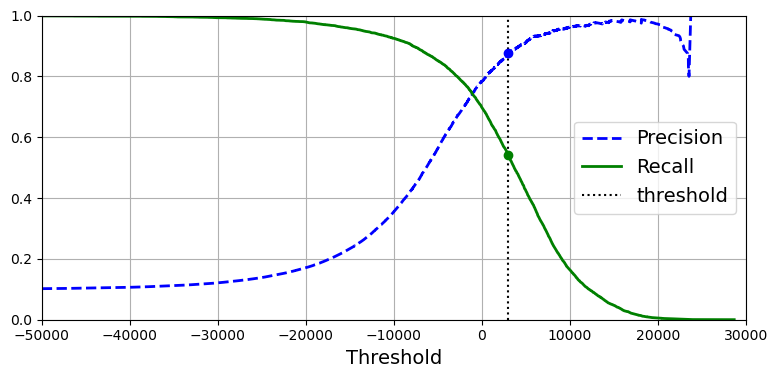

In [23]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 30000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

By looking at our code, we can see that our precision is close to 90%, and recall is close to 55% based on our threshold value of 3000. We will explore other graphs to gain more information.

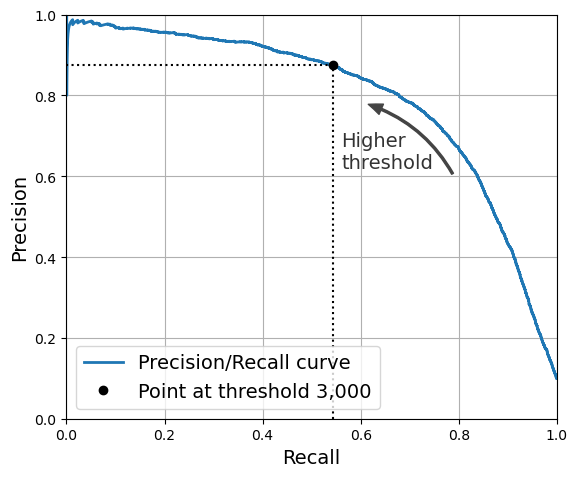

In [24]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

using NumPy, we can find what threshold we need for 90% precision. Based on the project, you can adjust if you want to focus on recall or precision.

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

4313.77382882831

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [28]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.465

So, we can see that we have a recall of 46.5% at 90% precision.

## The ROC curve

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

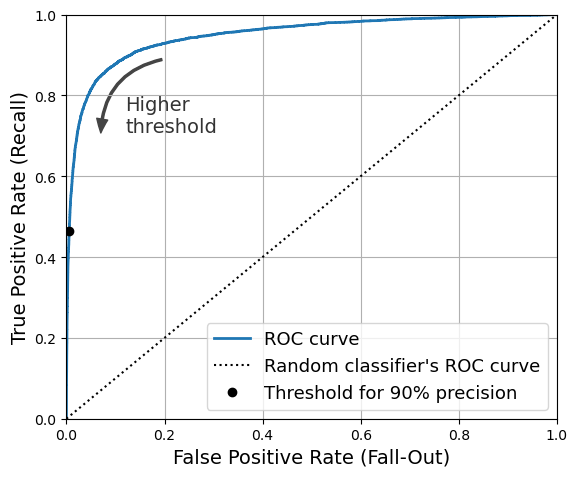

In [30]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

This helps us see that as we adjust the threshold, we will be introducing more false positives.

Although we get this information with the ROC curve, since we have a case where the positive class is rare, and we care more about false positives than false negatives, the PR curve is more relevant to our scenario.

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9485988456790122

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [33]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [34]:
y_probas_forest[:2]

array([[0.95, 0.05],
       [0.97, 0.03]])

Looking at this, we can see that it predicts the first image is positive with 95% probability, and that the second image is positive with 97% probability. (These are estimated probabilities)

In [35]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

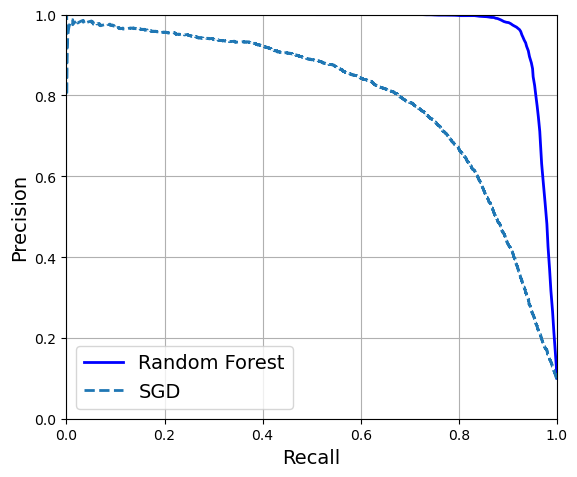

In [36]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

By comparing the two, we can see that the random forest classifier looks significantly better than the SGDClassifier. We will try out some other classifiers to see which one works best.
Now, we'll takea look at what our various scores are with the random forest classifier.

In [37]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9099800760731752

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9909210339506174

In [39]:
precision_score(y_train_5, y_train_pred_forest)

0.9964299880999603

In [40]:
recall_score(y_train_5, y_train_pred_forest)

0.8373333333333334

So we see that our precision score with this threshold is very close to 100%, and the recall is at 84%. Much better results than before. Now, we want to begin with detecting all of the classes.

## Multiclass Classification

In [41]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.7306 , 0.725  , 0.68465])

Just by scaling the inputs, we are able to improve the accuracy.

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.7851 , 0.7829 , 0.78195])

Now that we've gotten this far, we have a few different options to look at when it comes to fine-tuning our model. One we can try is the KNeighborsClassifier.

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9133

now, comparing that to the random forest classifier:

In [48]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
baseline_accuracy = forest_clf.score(X_test, y_test)
baseline_accuracy

0.8545

so we know that the KNeighborsClassifier is more accurate. Now, let's use a grid search on the weights and hyperparameters to see if we can improve it further. We will only use the first 10000 images so that the processing does not take too long.

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [50]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [51]:
grid_search.best_score_

0.93

So, the score improves to 93% using the best parameters. Since this value depends on what was used in the training set, we will try again on the full training set using the best parameters we've found.

In [52]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9191

However, this goes back down to 92%. This is not as good as it was on the base MNIST dataset, however considering our qualms at the start of the start of the project, it is quite acceptable.

If we want to improve further, one option would be to use convolutional neural networks. I have used them in the past for school work and so I believe I would be able to try it out and try to fine tune the values, however I believe it would not be helpful in this case, as my knowledge is limited. Rather than mess around with values and code I do not understand, I plan to continue following the textbook and eventually implement convolutional neural nets once I reach that section. Maybe once I've learned them, I'll come back to this project.

All that to say, I am happy with the results. I was able to demonstrate my understanding of chapter 3 of the textbook, and duplicate the results using a similar but different dataset. I will now move on to the next chapter, and continue my journey of machine learning.